In [1]:
import pickle
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from shapely import LineString, Point
from seaborn import displot, histplot, relplot, scatterplot
plt.style.use(['seaborn-v0_8-paper'])

from waymo_devkit.conflict import Conflict

In [2]:
with open('./pkl/conflict_pet15s.pkl', 'rb') as file:
    conflict_list_from_pickle = pickle.load(file)
print(f"#Conflicts: {len(conflict_list_from_pickle)}")

conflict_list = list()
for c in conflict_list_from_pickle:
    conflict_list.append(
        Conflict(
            leader_id=c['leader_id'],
            leader_index=c['leader_index'],
            leader_states=c['leader_states'],
            leader_time_at_conflict=c['leader_time_at_conflict'],
            follower_id=c['follower_id'],
            follower_index=c['follower_index'],
            follower_states=c['follower_states'],
            follower_time_at_conflict=c['follower_time_at_conflict'],
            PET=c['PET'],
            conflict_type=c['conflict_type'],
            leader_is_av=c['leader_is_av'],
            follower_is_av=c['follower_is_av'],
    ))

#Conflicts: 889


/home/gavin/waymo/waymo_devkit/conflict.py:149: RuntimeWarning: divide by zero encountered in double_scalars
  TTCs.append(follower_trajectory_length / (self.follower_beforeConflict_speeds[follower_index]))
/home/gavin/waymo/waymo_devkit/conflict.py:164: RuntimeWarning: divide by zero encountered in double_scalars
  follower_trajectory_length / self.follower_beforeConflict_speeds[follower_index] - \
/home/gavin/waymo/waymo_devkit/conflict.py:165: RuntimeWarning: divide by zero encountered in double_scalars
  leader_trajectory_length / self.leader_beforeConflict_speeds[leader_index]


In [87]:
conflict_cols_in_df = [
    # "tfrecord_index", 
    # "scenario_index",
    "conflict_type",
    "Vehicle order",
    "leader_type",
    "follower_type",
    "PET",
    "minTTC",
    "leader_minTTC_speed",
    "follower_minTTC_speed"
]

conflict_rows_in_df = list()
for index, conflict in enumerate(conflict_list):

    minTTC_speeds = conflict.minTTC_speeds
    if len(minTTC_speeds) == 0:
        # pass the special cases
        continue
    else:
        # normal cases with min TTC and speeds (3 elements in the list)
        # print(index)
        minTTC = minTTC_speeds[0]
        leader_minTTC_speed = minTTC_speeds[1]
        follower_minTTC_speed = minTTC_speeds[2]
        
        leader_type = "AV" if conflict.leader_is_av else "HV"
        follower_type = "AV" if conflict.follower_is_av else "HV" 
        conflict_type = "Cross" if conflict.conflict_type == "CROSS" else "Merge"
        conflict_rows_in_df.append([
            conflict_type,
            leader_type+"-"+follower_type,
            leader_type,
            follower_type,
            conflict.PET,
            minTTC,
            leader_minTTC_speed,
            follower_minTTC_speed,
        ])

conflict_df = pd.DataFrame(conflict_rows_in_df, columns=conflict_cols_in_df)

"""
Post-process
- Only consider PET <= 10s
"""
PET_THRESHOLD = 10
minTTC_THRESHOLD = 10

conflict_df = conflict_df[conflict_df["PET"] <= PET_THRESHOLD]
conflict_df = conflict_df[conflict_df["minTTC"] <= minTTC_THRESHOLD]

conflict_df.info()
conflict_df.to_csv("./outputs/waymo_heatmap_speeds_minTTC.csv")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 690 entries, 0 to 846
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   conflict_type          690 non-null    object 
 1   Vehicle order          690 non-null    object 
 2   leader_type            690 non-null    object 
 3   follower_type          690 non-null    object 
 4   PET                    690 non-null    float64
 5   minTTC                 690 non-null    float64
 6   leader_minTTC_speed    690 non-null    float64
 7   follower_minTTC_speed  690 non-null    float64
dtypes: float64(4), object(4)
memory usage: 48.5+ KB


In [79]:
conflict_df.head()

,conflict_type,Vehicle order,leader_type,follower_type,PET,minTTC,leader_minTTC_speed,follower_minTTC_speed
0,Cross,AV-HV,AV,HV,2.9,3.468932,1.641930,7.514917
1,Cross,AV-HV,AV,HV,3.0,3.591701,0.001394,5.091792
2,Cross,HV-HV,HV,HV,3.8,7.217758,3.626650,2.501328
3,Cross,AV-HV,AV,HV,2.4,3.654863,6.673838,5.682852
4,Cross,AV-HV,AV,HV,2.6,2.999414,7.800697,3.781994


In [80]:
HVHV_df = conflict_df[conflict_df["Vehicle order"] == "HV-HV"]
HVAV_df = conflict_df[conflict_df["Vehicle order"] == "HV-AV"]
AVHV_df = conflict_df[conflict_df["Vehicle order"] == "AV-HV"]

Text(0, 0.5, 'Leader speed')

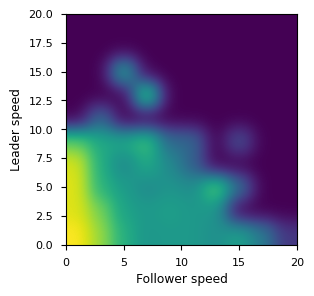

In [82]:
# discretize v1 和 v2
nbins = 10
bins = np.linspace(0, 20, nbins + 1)

plt.figure(figsize=(3,3))

order = "HV-HV"
df = conflict_df

df['leader_minTTC_speed_bins'] = pd.cut(df['leader_minTTC_speed'], bins=bins, labels=np.arange(nbins), include_lowest=True)
df['follower_minTTC_speed_bins'] = pd.cut(df['follower_minTTC_speed'], bins=bins, labels=np.arange(nbins), include_lowest=True)

# 计算每个网格中 height 的平均值
grid_avg = df.groupby(['leader_minTTC_speed_bins', 'follower_minTTC_speed_bins'])['minTTC'].mean().unstack()
grid_avg = np.nan_to_num(grid_avg, 0)
plt.imshow(grid_avg, interpolation="gaussian", extent=[0, 20, 0, 20], origin='lower', interpolation_stage="data")
# plt.colorbar()
plt.xlabel("Follower speed")
plt.ylabel("Leader speed")
# plt.title(order)

/tmp/ipykernel_494524/451682921.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['leader_minTTC_speed_bins'] = pd.cut(df['leader_minTTC_speed'], bins=bins, labels=np.arange(nbins), include_lowest=True)
/tmp/ipykernel_494524/451682921.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['follower_minTTC_speed_bins'] = pd.cut(df['follower_minTTC_speed'], bins=bins, labels=np.arange(nbins), include_lowest=True)


Text(0.5, 1.0, 'HV-HV (Waymo)')

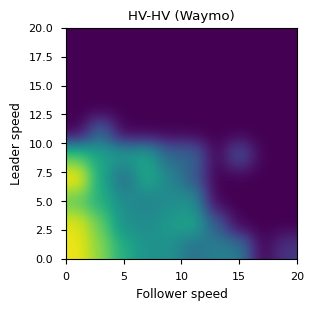

In [84]:
# discretize v1 和 v2
nbins = 10
bins = np.linspace(0, 20, nbins + 1)

plt.figure(figsize=(3,3))

order = "HV-HV"
df = conflict_df[conflict_df["Vehicle order"] == order]

df['leader_minTTC_speed_bins'] = pd.cut(df['leader_minTTC_speed'], bins=bins, labels=np.arange(nbins), include_lowest=True)
df['follower_minTTC_speed_bins'] = pd.cut(df['follower_minTTC_speed'], bins=bins, labels=np.arange(nbins), include_lowest=True)

# 计算每个网格中 height 的平均值
grid_avg = df.groupby(['leader_minTTC_speed_bins', 'follower_minTTC_speed_bins'])['minTTC'].mean().unstack()
grid_avg = np.nan_to_num(grid_avg, 0)
plt.imshow(grid_avg, interpolation="gaussian", extent=[0, 20, 0, 20], origin='lower', interpolation_stage="data")
# plt.colorbar()
plt.xlabel("Follower speed")
plt.ylabel("Leader speed")
plt.title(order+ " (Waymo)")

/tmp/ipykernel_494524/3225701910.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['leader_minTTC_speed_bins'] = pd.cut(df['leader_minTTC_speed'], bins=bins, labels=np.arange(nbins), include_lowest=True)
/tmp/ipykernel_494524/3225701910.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['follower_minTTC_speed_bins'] = pd.cut(df['follower_minTTC_speed'], bins=bins, labels=np.arange(nbins), include_lowest=True)


Text(0.5, 1.0, 'HV-AV (Waymo)')

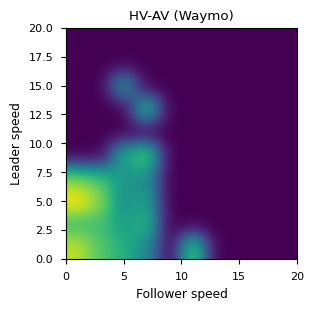

In [85]:
# discretize v1 和 v2
nbins = 10
bins = np.linspace(0, 20, nbins + 1)

plt.figure(figsize=(3,3))

order = "HV-AV"
df = conflict_df[conflict_df["Vehicle order"] == order]

df['leader_minTTC_speed_bins'] = pd.cut(df['leader_minTTC_speed'], bins=bins, labels=np.arange(nbins), include_lowest=True)
df['follower_minTTC_speed_bins'] = pd.cut(df['follower_minTTC_speed'], bins=bins, labels=np.arange(nbins), include_lowest=True)

# 计算每个网格中 height 的平均值
grid_avg = df.groupby(['leader_minTTC_speed_bins', 'follower_minTTC_speed_bins'])['minTTC'].mean().unstack()
grid_avg = np.nan_to_num(grid_avg, 0)
plt.imshow(grid_avg, interpolation="gaussian", extent=[0, 20, 0, 20], origin='lower', interpolation_stage="data")
# plt.colorbar()
plt.xlabel("Follower speed")
plt.ylabel("Leader speed")
plt.title(order + " (Waymo)")

/tmp/ipykernel_494524/1622851269.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['leader_minTTC_speed_bins'] = pd.cut(df['leader_minTTC_speed'], bins=bins, labels=np.arange(nbins), include_lowest=True)
/tmp/ipykernel_494524/1622851269.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['follower_minTTC_speed_bins'] = pd.cut(df['follower_minTTC_speed'], bins=bins, labels=np.arange(nbins), include_lowest=True)


Text(0.5, 1.0, 'AV-HV (Waymo)')

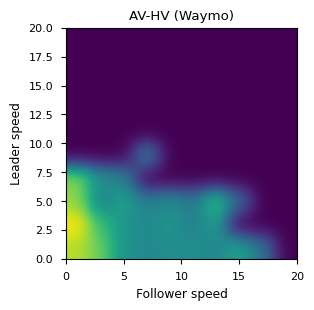

In [86]:
# discretize v1 和 v2
nbins = 10
bins = np.linspace(0, 20, nbins + 1)

plt.figure(figsize=(3,3))

order = "AV-HV"
df = conflict_df[conflict_df["Vehicle order"] == order]

df['leader_minTTC_speed_bins'] = pd.cut(df['leader_minTTC_speed'], bins=bins, labels=np.arange(nbins), include_lowest=True)
df['follower_minTTC_speed_bins'] = pd.cut(df['follower_minTTC_speed'], bins=bins, labels=np.arange(nbins), include_lowest=True)

# 计算每个网格中 height 的平均值
grid_avg = df.groupby(['leader_minTTC_speed_bins', 'follower_minTTC_speed_bins'])['minTTC'].mean().unstack()
grid_avg = np.nan_to_num(grid_avg, 0)
plt.imshow(grid_avg, interpolation="gaussian", extent=[0, 20, 0, 20], origin='lower', interpolation_stage="data")
# plt.colorbar()
plt.xlabel("Follower speed")
plt.ylabel("Leader speed")
plt.title(order + " (Waymo)")

## Not wanted